Below lines are only for downloading dataset and checking resources.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=avilaJorge&password=C323781C&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

In [0]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=avilaJorge&password=C323781C&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

In [0]:
import zipfile
with zipfile.ZipFile('leftImg8bit_trainvaltest.zip', 'r') as zip_ref:
    zip_ref.extractall('./Data')
with zipfile.ZipFile('gtFine_trainvaltest.zip', 'r') as zip_ref:
    zip_ref.extractall('./Data')

In [0]:
# !cp -nR ./datasets/. ./drive/My\ Drive/CSE253/datasets
!mv ./Data ./cityscapes
!mkdir datasets
!mv ./cityscapes ./datasets/cityscapes
!rm ./leftImg8bit_trainvaltest.zip
!rm ./gtFine_trainvaltest.zip

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')


------------- Code Starts Here -----------

In [0]:
from torchvision import utils
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch
import time
from datetime import datetime

import matplotlib.pyplot as plt

plt.ion()   # interactive mod

In [0]:
class FCN8S(nn.Module):

    def __init__(self, n_class):
        super(FCN8S, self).__init__()
        self.n_class = n_class
        self.relu    = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(2, stride=2) 
        self.conv11 = nn.Conv2d(3,  64, kernel_size=3, stride=1, padding=100, dilation=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv21 = nn.Conv2d(64,  128, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7, padding=0)
        self.dropout6 = nn.Dropout2d(p=0.5, inplace=True)

        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1, padding=0)
        self.dropout7 = nn.Dropout(p=0.5, inplace=True)

        self.clsfr1 = nn.Conv2d(4096, self.n_class, kernel_size=1, padding=0)
        self.clsfr2 = nn.Conv2d(512, self.n_class, kernel_size=1, padding=0)
        self.clsfr3 = nn.Conv2d(256, self.n_class, kernel_size=1, padding=0)

        self.deconv1 = nn.ConvTranspose2d(self.n_class, self.n_class, kernel_size=4, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(self.n_class, self.n_class, kernel_size=4, stride=2, padding=0)
        self.deconv3 = nn.ConvTranspose2d(self.n_class, self.n_class, kernel_size=16, stride=8, padding=0)

    def __conv_relu(self, input, conv, pool=None):
        if pool is None:
          return self.relu(conv(input))
        else:
          return pool(self.relu(conv(input)))


    def forward(self, x):
        z = self.__conv_relu(x, self.conv11)
        z = self.__conv_relu(z, self.conv12, self.pool)

        z = self.__conv_relu(z, self.conv21)
        z = self.__conv_relu(z, self.conv22, self.pool)

        z = self.__conv_relu(z, self.conv31)
        z = self.__conv_relu(z, self.conv32)
        sp3 = self.__conv_relu(z, self.conv33, self.pool)

        z = self.__conv_relu(sp3, self.conv41)
        z = self.__conv_relu(z, self.conv42)
        sp4 = self.__conv_relu(z, self.conv43, self.pool)

        z = self.__conv_relu(sp4, self.conv51)
        z = self.__conv_relu(z, self.conv52)
        z = self.__conv_relu(z, self.conv53, self.pool)

        z = self.dropout6(self.__conv_relu(z, self.conv6))

        sfr = self.dropout7(self.__conv_relu(z, self.conv7))

        ups2 = self.deconv1(self.clsfr1(sfr))
        sp4  = self.clsfr2(sp4)
        sp3  = self.clsfr3(sp3)
        cropped = sp4[:, :, 10:(10 + ups2.size()[2]), 10:(10 + ups2.size()[3])]
        ups4 = self.deconv2(sp4[:, :, 10:(10 + ups2.size()[2]), 10:(10 + ups2.size()[3])] + ups2)
        ups3 = self.deconv3(sp3[:, :, 18:(18 + ups4.size()[2]), 18:(18 + ups4.size()[3])] + ups4)
        score = ups3[:, :, 56: (56 + x.size(2)), 56: (56 + x.size(3))].contiguous()
        return score

In [0]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def print_GPU_stats():
    print("total GPU Mem: ", torch.cuda.get_device_properties(device).total_memory)
    print("total GPU Cached: ", torch.cuda.memory_cached(device))
    print("total GPU Allocated: ", torch.cuda.memory_allocated(device))
    print("Available GB: ", (torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_allocated(device))/(10**9))
print_GPU_stats()

cuda:0
total GPU Mem:  17071734784
total GPU Cached:  0
total GPU Allocated:  0
Available GB:  17.071734784


In [0]:
trn_batch_size = 12
val_batch_size = 4
num_wrkrs = 4
train_dataset = CityScapesDatasetResize(csv_file='train_local.csv')
val_dataset = CityScapesValidationDataset(csv_file='val_local.csv')
test_dataset = CityScapesValidationDataset(csv_file='test_local.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=trn_batch_size,
                          num_workers=num_wrkrs,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=val_batch_size,
                          num_workers=num_wrkrs,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=val_batch_size,
                          num_workers=num_wrkrs,
                          shuffle=True)

In [0]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

epochs     = 100
start_epoch = 1
path = '/content/drive/My Drive/CSE253/PA3/FCN8S/'
criterion = torch.nn.CrossEntropyLoss()
fcn_model = FCN8S(n_class=34)
fcn_model.apply(init_weights)
# fcn_model.load_state_dict(torch.load(path + 'best_model_02_16_07_22.pt'))
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-5, weight_decay=1e-5)

In [7]:
dt = datetime.now().strftime("%m_%d_%H_%M")
output_fn = path + "model_output_" + dt + ".txt"
best_model_fn = path + "best_model_" + dt + ".pt"
model_fn = path + "model_" + dt + ".pt"

def print_info(out_str):
    f = open(output_fn,"a")
    print(out_str)
    f.write(out_str)
    f.close()

# print_info("Started: %s\nFrom a previously trained model which left off on start of epoch 9.\n" % datetime.now())
print_info("Started: %s\n" % datetime.now())

Started: 2020-02-16 21:12:20.620274



In [0]:
use_gpu = torch.cuda.is_available()
# use_gpu = False
if use_gpu:
    fcn_model = fcn_model.to(device)
    
best_loss = float('inf')
prev_loss = float('inf')
loss_inc_cnt = 0
stop_early = False

def train():
    softmax = nn.Softmax(dim=1)
    print("Starting Training")

    for epoch in range(start_epoch, epochs):
        trn_losses = MovingAverage()
        trn_accs = MovingAverage()
        trn_ious = MovingAverage()
        ts = time.time()
        for iter, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = X.to(device)
                labels_cat = Y.to(device)
            else:
                inputs, labels_cat, labels_enc = X, Y, tar
            
            outputs = softmax(fcn_model(inputs))
            loss = criterion(outputs, labels_cat)
            loss.backward()
            optimizer.step()
            loss = loss.item()

            output_labels = outputs.argmax(dim=1)

            trn_losses.update(loss)
            trn_accs.update(pixel_acc(output_labels, labels_cat))
            trn_ious.update(np.nanmean(iou(output_labels, labels_cat)))
            
            if iter % 10 == 0:
                print_info("epoch{}, iter{}, loss: {} \n".format(epoch, iter, loss))
                
        
        print_info("Finish epoch {}, time elapsed {} \n".format(epoch, time.time() - ts))
    
        loss, acc, IoU = trn_losses.value, trn_accs.value, trn_ious.value 

        print_info("Training Check:\tLoss: %f\tAccuracy: %f\tIoU: %f \n" % (loss, acc * 100, IoU))
        
        val(epoch)

        if stop_early: return

def evaluate(data_loader, validation=False, verbose=False):

    global best_loss
    global prev_loss
    global loss_inc_cnt
    global stop_early
    
    with torch.no_grad():
        losses = RunningAverage()
        accs = RunningAverage()
        ious = RunningAverage()
        softmax = nn.Softmax(dim=1)
        ts = time.time()
        print("Starting Evaluation")
        
        for iter, (X, tar, Y) in enumerate(data_loader):

            if use_gpu:
                inputs = X.to(device)
                labels_cat = Y.to(device)
            else:
                inputs, labels_cat, labels_enc = X, Y, tar

            outputs = softmax(fcn_model(inputs))
            outputs = torch.nn.functional.interpolate(input=outputs, size=(1024,2048))

            output_labels = outputs.argmax(dim=1)

            losses.update(criterion(outputs, labels_cat).item())

            accs.update(pixel_acc(output_labels, labels_cat))

            ious.update(np.nanmean(iou(output_labels, labels_cat)))

        print_info("Finished evaluation. Time elapsed %f\n" % (time.time() - ts))

        # This probably should not be a straight average, but just doing this for now
        loss = losses.value 
        acc = accs.value 
        IoU = ious.value 
        
        if validation:
            if best_loss > loss:
                best_loss = loss
                print_info("Best Loss: " + str(best_loss) + "\n")
                torch.save(fcn_model.state_dict(), best_model_fn)
            loss_inc_cnt = loss_inc_cnt + 1 if prev_loss < loss else 0
            if loss_inc_cnt > 2: stop_early = True
            torch.save(fcn_model.state_dict(), model_fn)
        
        return loss, acc, IoU

def val(epoch):
    # fcn_model.eval()
    # Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    loss, acc, IoU = evaluate(val_loader, validation=True)
    print_info("Validation Results: Loss: %f\tAccuracy: %f\tIoU: %f \n" % (loss, acc * 100, IoU))
    if stop_early: print_info("Epoch %d:\tStopping Early" % (epoch))
    
def test():
    print(' ')
    # Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    loss, acc, IoU = evaluate(test_loader)
    print_info("Test Results:\tLoss: %f\tAccuracy: %f\tIoU: %f \n" % (loss, acc * 100, IoU))
    
if __name__ == "__main__":
    # val(0)  # show the accuracy before training
    # print_info("---------Above is accuracy before training.---------\n")
    train()
    # test()

Starting Training
epoch1, iter0, loss: 2.7056102752685547 

epoch1, iter10, loss: 2.730027437210083 

epoch1, iter20, loss: 2.7134037017822266 

epoch1, iter30, loss: 2.747056245803833 

epoch1, iter40, loss: 2.707852363586426 

epoch1, iter50, loss: 2.6959946155548096 

epoch1, iter60, loss: 2.7141292095184326 



In [0]:
def imshow_test(img):
    H = img.size()[0]
    W = img.size()[1]
    test_colored = torch.zeros(H,W,3)
    for row in range(H):
      for col in range(W):
        test_colored[row][col][0] =  labels_classes[img[row][col]].color[0]
        test_colored[row][col][1] =  labels_classes[img[row][col]].color[1]
        test_colored[row][col][2] =  labels_classes[img[row][col]].color[2]
    print(img.size())   # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

def test_img(data_loader):

    with torch.no_grad():
        softmax = nn.Softmax(dim=1)
        ts = time.time()
        outputs = []
        output_labels = []
        print("Starting Testing")
        
        for iter, (X, tar, Y) in enumerate(data_loader):

            inputs = X.to(device)
            labels_cat = Y.to(device)

            outputs = softmax(fcn_model(inputs))

            output_labels = outputs.argmax(dim=1)

        print_info("Finished evaluation. Time elapsed %f\n" % (time.time() - ts))
        return outputs, output_labels

In [0]:
num_wrkrs = 4
test_dataset_resized = CityScapesDatasetResize(csv_file='img_drive.csv')
test_dataset = CityScapesDataset(csv_file='img_drive.csv')
test_resized_loader = DataLoader(dataset=test_dataset_resized,
                          batch_size=1,
                          num_workers=num_wrkrs,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          num_workers=num_wrkrs,
                          shuffle=True)

torch.Size([1024, 2048])


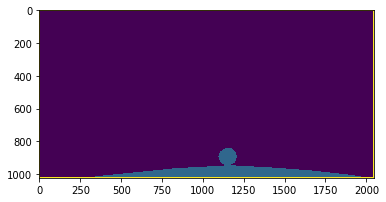

Starting Testing
Finished evaluation. Time elapsed 0.664043

torch.Size([1024, 2048])


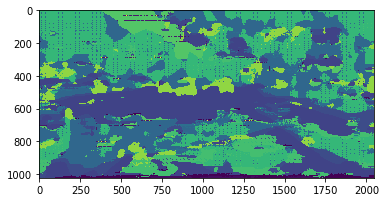

Starting Testing
Finished evaluation. Time elapsed 0.631241

torch.Size([256, 512])


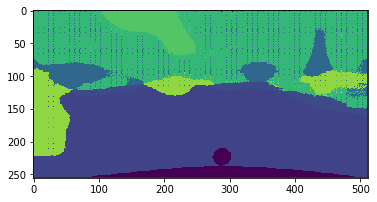

In [34]:
from utils_2 import *

epochs     = 100
start_epoch = 1
path = '/content/drive/My Drive/CSE253/PA3/FCN8S/'
criterion = torch.nn.CrossEntropyLoss()
fcn_model = FCN8S(n_class=34)

fcn_model.load_state_dict(torch.load(path + 'best_model_02_16_07_22.pt'))
fcn_model = fcn_model.to(device)
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-5, weight_decay=1e-5)

imgs, _, labels = next(iter(test_loader))
imgs_resized, _, labels_resized = next(iter(test_resized_loader))

imshow_test(labels.squeeze(0))

img, lbls = test_img(test_loader)
imshow_test(lbls.squeeze(0).cpu())

resized_img, resized_lbls = test_img(test_resized_loader)
imshow_test(resized_lbls.squeeze(0).cpu())

ups_img = torch.nn.functional.interpolate(input=resized_lbls, size=(1024, 2048))
imshow_test(ups_img.squeeze(0).cpu())